In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text

from IPython.display import display

In [2]:
!head data/CreditScoring.csv

/bin/bash: /home/hilbert/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [3]:
df = pd.read_csv("data/CreditScoring.csv")
print(df.shape)
df.info()

(4455, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Status     4455 non-null   int64
 1   Seniority  4455 non-null   int64
 2   Home       4455 non-null   int64
 3   Time       4455 non-null   int64
 4   Age        4455 non-null   int64
 5   Marital    4455 non-null   int64
 6   Records    4455 non-null   int64
 7   Job        4455 non-null   int64
 8   Expenses   4455 non-null   int64
 9   Income     4455 non-null   int64
 10  Assets     4455 non-null   int64
 11  Debt       4455 non-null   int64
 12  Amount     4455 non-null   int64
 13  Price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [5]:
status_valus = {1: "ok", 2: "default", 3: "unk"}
df.status = df.status.map(status_valus)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [6]:
for c in ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [7]:
df = df[df.status != "unk"].reset_index(drop=True)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
ytr = (df_train.status == "default").astype("int").values
yvl = (df_val.status == "default").astype("int").values
yts = (df_test.status == "default").astype("int").values

In [11]:
del df_train["status"]
del df_val["status"]
del df_test["status"]

In [12]:
train_dicts = df_train.fillna(0).to_dict(orient="records")
dv = DictVectorizer(sparse=False)
xtr = dv.fit_transform(train_dicts)
print(dv.get_feature_names_out()[:10])

['age' 'amount' 'assets' 'debt' 'expenses' 'home=ignore' 'home=other'
 'home=owner' 'home=parents' 'home=private']


In [13]:
dt =  DecisionTreeClassifier()
dt.fit(xtr, ytr)

DecisionTreeClassifier()

In [14]:
val_dicts = df_val.fillna(0).to_dict(orient="records")

xvl =  dv.fit_transform(val_dicts)
ypr = dt.predict_proba(xvl)[:, 1]
auc = roc_auc_score(yvl, ypr)
print(auc)

ypr = dt.predict_proba(xtr)[:, 1]
auc = roc_auc_score(ytr, ypr)
print(auc)

0.6593962842556769
1.0


In [15]:
dt =  DecisionTreeClassifier(max_depth=3)
dt.fit(xtr, ytr)

ypr = dt.predict_proba(xvl)[:, 1]
auc = roc_auc_score(yvl, ypr)
print(auc)

ypr = dt.predict_proba(xtr)[:, 1]
auc = roc_auc_score(ytr, ypr)
print(auc)

0.763427236430611
0.7660925386129352


In [16]:
print(export_text(dt))

|--- feature_25 <= 0.50
|   |--- feature_16 <= 0.50
|   |   |--- feature_12 <= 73.50
|   |   |   |--- class: 0
|   |   |--- feature_12 >  73.50
|   |   |   |--- class: 0
|   |--- feature_16 >  0.50
|   |   |--- feature_27 <= 27.00
|   |   |   |--- class: 0
|   |   |--- feature_27 >  27.00
|   |   |   |--- class: 1
|--- feature_25 >  0.50
|   |--- feature_26 <= 6.50
|   |   |--- feature_12 <= 50.50
|   |   |   |--- class: 1
|   |   |--- feature_12 >  50.50
|   |   |   |--- class: 1
|   |--- feature_26 >  6.50
|   |   |--- feature_12 <= 99.50
|   |   |   |--- class: 1
|   |   |--- feature_12 >  99.50
|   |   |   |--- class: 0



In [25]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [21]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [26]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [27]:
thresholds = {
    "assets": [0, 2000, 3000, 4000, 5000, 8000],
    "debt": [500, 1000, 2000]
}

Ts = [0, 2000, 3000, 4000, 5000, 8000]
for feature, Ts in thresholds.items():
    print("====================")
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
        print()
    print("====================")

assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64



In [37]:
for d in [1, 3, 4, 5, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(xtr, ytr)
    ypred = dt.predict_proba(xvl)[:, 1]
    auc = roc_auc_score(yvl, ypred)

    print("%4s -> %.3f" % (d, auc))

   1 -> 0.613
   3 -> 0.763
   4 -> 0.779
   5 -> 0.775
  10 -> 0.697
  15 -> 0.683
  20 -> 0.653
None -> 0.656


In [40]:
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(xtr, ytr)
        ypred = dt.predict_proba(xvl)[:, 1]
        auc = roc_auc_score(yvl, ypred)

        print("(%4s, %3d) -> %.3f" % (d, s, auc))

(   4,   1) -> 0.779
(   4,   2) -> 0.779
(   4,   5) -> 0.779
(   4,  10) -> 0.774
(   4,  15) -> 0.771
(   4,  20) -> 0.784
(   4, 100) -> 0.767
(   4, 200) -> 0.765
(   4, 500) -> 0.671
(   5,   1) -> 0.776
(   5,   2) -> 0.774
(   5,   5) -> 0.779
(   5,  10) -> 0.783
(   5,  15) -> 0.780
(   5,  20) -> 0.785
(   5, 100) -> 0.786
(   5, 200) -> 0.778
(   5, 500) -> 0.671
(   6,   1) -> 0.769
(   6,   2) -> 0.772
(   6,   5) -> 0.781
(   6,  10) -> 0.797
(   6,  15) -> 0.801
(   6,  20) -> 0.809
(   6, 100) -> 0.793
(   6, 200) -> 0.789
(   6, 500) -> 0.671


In [45]:
scores = []
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(xtr, ytr)

        ypred = dt.predict_proba(xvl)[:, 1]
        auc = roc_auc_score(yvl, ypred)

        scores.append((d, s, auc))

scores = pd.DataFrame(
    scores, 
    columns=["max_depth", "min_samples_leaf", "auc"]
)

scores.sort_values("auc", ascending=False)[:5]

,max_depth,min_samples_leaf,auc
23,6,20,0.809361
22,6,15,0.800217
21,6,10,0.796360
24,6,100,0.793276
25,6,200,0.788792


In [48]:
scores_pivot = scores.pivot(index="min_samples_leaf", columns=["max_depth"], values=["auc"])
scores_pivot

auc                    
max_depth                4         5         6
min_samples_leaf                              
1                 0.779339  0.776008  0.767355
2                 0.779339  0.774438  0.770476
5                 0.779339  0.776076  0.783273
10                0.773804  0.783199  0.796360
15                0.770739  0.780109  0.800217
20                0.783517  0.785229  0.809361
100               0.766987  0.786425  0.793276
200               0.764929  0.777955  0.788792
500               0.671368  0.671368  0.671368

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

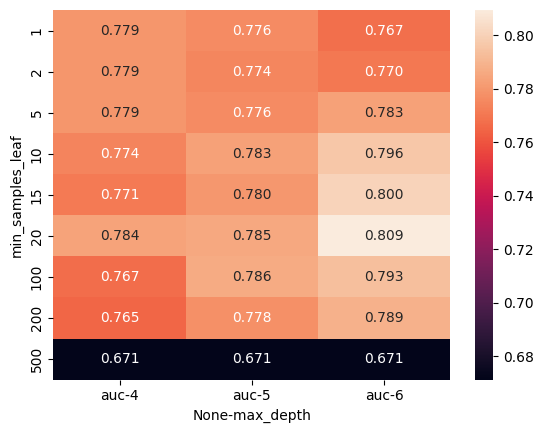

In [52]:
sns.heatmap(scores_pivot, annot=True, fmt=".3f")

In [57]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(xtr, ytr)
ypred = rf.predict_proba(xvl)[:,1]
print(roc_auc_score(yvl, ypred))

0.8054178667227035


In [60]:
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(xtr, ytr)
    ypred = rf.predict_proba(xvl)[:,1]
    print("%3s -> %.3f" % (n, roc_auc_score(yvl, ypred)))

 10 -> 0.805
 20 -> 0.820
 30 -> 0.819
 40 -> 0.822
 50 -> 0.826
 60 -> 0.826
 70 -> 0.828
 80 -> 0.830
 90 -> 0.830
100 -> 0.831
110 -> 0.832
120 -> 0.833
130 -> 0.833
140 -> 0.834
150 -> 0.835
160 -> 0.835
170 -> 0.834
180 -> 0.834
190 -> 0.835
200 -> 0.835


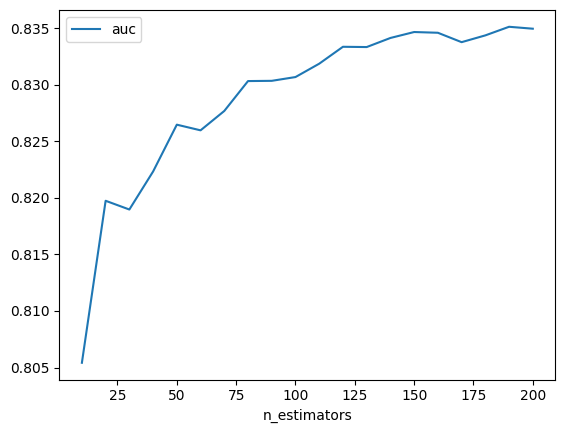

In [62]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(xtr, ytr)
    ypred = rf.predict_proba(xvl)[:,1]
    scores.append((n, roc_auc_score(yvl, ypred)))

pd.DataFrame(scores, columns=['n_estimators', 'auc']).plot(
    x='n_estimators', y='auc', kind='line'
)

In [66]:
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(xtr, ytr)
        ypred = rf.predict_proba(xvl)[:,1]
        scores.append((d, n, roc_auc_score(yvl, ypred)))

scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
scores.head()

,max_depth,n_estimators,auc
0,5,10,0.812170
1,5,20,0.819565
2,5,30,0.819256
3,5,40,0.821246
4,5,50,0.826290


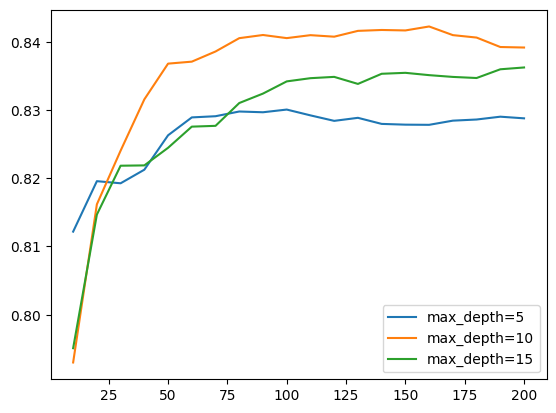

In [70]:
for d in [5, 10, 15]:
    df_subset = scores[scores.max_depth == d]
    plt.plot(
        df_subset.n_estimators,
        df_subset.auc,
        label=f"max_depth={d}"
    )
plt.legend();

In [75]:
max_depth = 10

scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=n, 
            max_depth=max_depth, 
            min_samples_leaf=s,
            random_state=1
        )
        rf.fit(xtr, ytr)
        ypred = rf.predict_proba(xvl)[:,1]
        scores.append((s, n, roc_auc_score(yvl, ypred)))

scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.792995
1,1,20,0.816172
2,1,30,0.824034
3,1,40,0.831555
4,1,50,0.836790


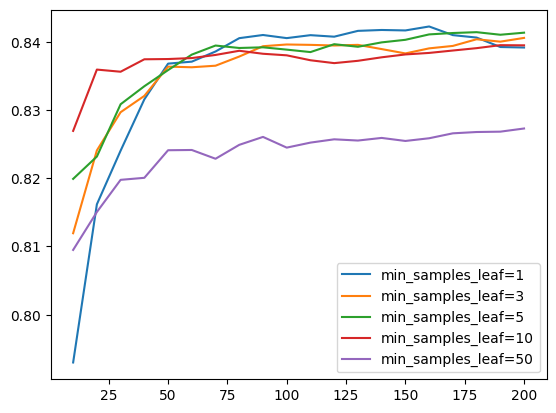

In [76]:
for s in [1, 3, 5, 10, 50]:
    df_subset = scores[scores.min_samples_leaf == s]
    plt.plot(
        df_subset.n_estimators,
        df_subset.auc,
        label=f"min_samples_leaf={s}"
    )
plt.legend();

In [79]:
features = dv.get_feature_names_out()
dtr = xgb.DMatrix(xtr, label=ytr, feature_names=features)
dvl = xgb.DMatrix(xvl, label=yvl, feature_names=features)

In [88]:
%%capture output

watchlist = [(dtr, 'train'), (dvl, 'valid')]

xgb_params = {
    "eta": 0.3, # learning rate 
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": -1,
    "seed": 1,
    "verbosity": 1    
}

model = xgb.train(
    xgb_params,
    dtr,
    num_boost_round=200,
    verbose_eval=5,
    evals=watchlist,
)

In [93]:
print(output.stdout)
s = output.stdout

[0]	train-auc:0.84697	valid-auc:0.78329
[5]	train-auc:0.92374	valid-auc:0.81330
[10]	train-auc:0.95016	valid-auc:0.82497
[15]	train-auc:0.96575	valid-auc:0.82266
[20]	train-auc:0.97463	valid-auc:0.82023
[25]	train-auc:0.98257	valid-auc:0.81903
[30]	train-auc:0.98565	valid-auc:0.81523
[35]	train-auc:0.98934	valid-auc:0.81370
[40]	train-auc:0.99299	valid-auc:0.81458
[45]	train-auc:0.99525	valid-auc:0.81618
[50]	train-auc:0.99690	valid-auc:0.81669
[55]	train-auc:0.99823	valid-auc:0.81960
[60]	train-auc:0.99881	valid-auc:0.81902
[65]	train-auc:0.99905	valid-auc:0.81712
[70]	train-auc:0.99941	valid-auc:0.81780
[75]	train-auc:0.99958	valid-auc:0.81533
[80]	train-auc:0.99977	valid-auc:0.81339
[85]	train-auc:0.99989	valid-auc:0.81429
[90]	train-auc:0.99995	valid-auc:0.81376
[95]	train-auc:0.99999	valid-auc:0.81351
[100]	train-auc:1.00000	valid-auc:0.81474
[105]	train-auc:1.00000	valid-auc:0.81454
[110]	train-auc:1.00000	valid-auc:0.81562
[115]	train-auc:1.00000	valid-auc:0.81573
[120]	train-au

In [95]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

df_score = parse_xgb_output(output)

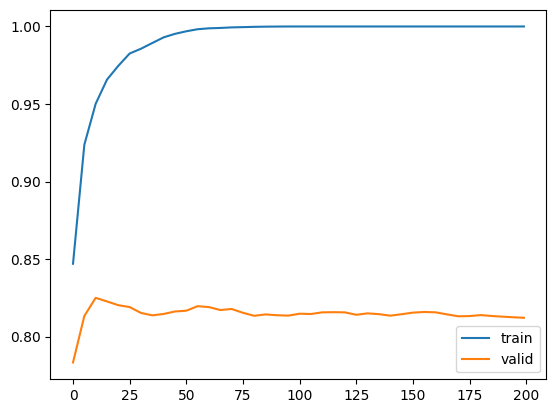

In [97]:
plt.plot(df_score.num_iter, df_score.train_auc, label="train")
plt.plot(df_score.num_iter, df_score.val_auc, label="valid")
plt.legend();